In [1]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc as misc
import cv2 as cv2
%matplotlib inline


In [50]:
files = glob.glob("../bagfiles/remote_control/images/*.jpg")
df = pd.DataFrame(files, columns=["file"])
df.head()
df["steer"] = df["file"].replace(to_replace="(.*)?leftimage_", value="", regex=True)
df["steer"] = df["steer"].replace(to_replace=".jpg", value="", regex=True)
df["steer"] = pd.to_numeric(df["steer"])
print(df.dtypes)
df.head()
df.shape

file      object
steer    float64
dtype: object


(3284, 2)

../bagfiles/remote_control/images/0.82827-leftimage_0.0957064181566.jpg
(376, 672, 3)


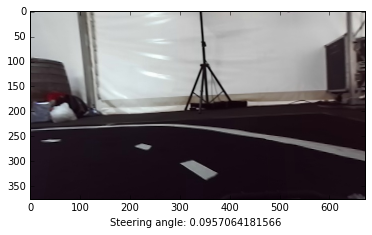

In [51]:
def show_image(index):
    print(df['file'][index])
    image = mpimg.imread(df['file'][index])
    print(image.shape)
    plt.imshow(image)
    plt.xlabel("Steering angle: {} ".format(df['steer'][index]))

show_image(130)

In [52]:
def shuffle_images(df): 
    mask = df["steer"] == 0
    zeros = df[mask]
    nonzeros = df[mask==False]
    sample_size = int(zeros.shape[0]*0.15)
    zero_sample = zeros.sample(n=sample_size)
    
    return zero_sample.append(nonzeros).sample(frac=1).reset_index(drop=True)

sample = shuffle_images(df)
print(sample.shape[0])

2371


(3284, 64, 64, 3)
(3284, 1)
[[  2.44422808e-01]
 [ -9.77887030e-05]
 [  0.00000000e+00]
 [ -9.21533257e-02]
 [  8.86316746e-02]]


(array([  117.,   112.,   224.,   252.,   206.,  1356.,   371.,   329.,
          238.,    79.]),
 array([-0.34 , -0.272, -0.204, -0.136, -0.068,  0.   ,  0.068,  0.136,
         0.204,  0.272,  0.34 ]),
 <a list of 10 Patch objects>)

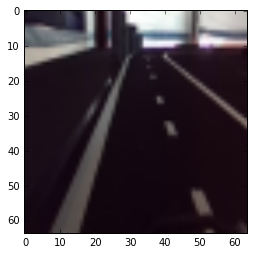

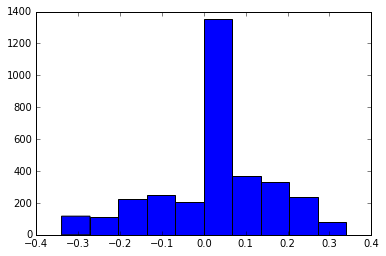

In [53]:
def get_images(df): 
    result = [] 
    for path in df["file"]:
        try:
            img = cv2.imread(path)
            img = img[150:, :]
    #         img = misc.imresize(img, (113,168))
            img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
            result.append(img)
        except: 
            print(path)
            continue
    return np.stack(result)

x = get_images(df)
print(x.shape)
y = df.as_matrix(columns=['steer'])
plt.imshow(x[0])
print(y.shape)
print(y[10:15])
plt.figure()
plt.hist(y)

In [6]:
# TODO: Build a model
import keras
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Input
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization
from keras.regularizers import l2

def Nvidia():
    model = Sequential()
#     model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))
    model.add(Conv2D(24, (3, 3), strides=(2, 2), padding="same", activation="relu", input_shape=(113,168,3)))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Conv2D(36, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Conv2D(48, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1000, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    adam = Adam(lr=0.001)
    model.compile(adam, 'mae')
    return model

model = Nvidia()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 57, 84, 24)        672       
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 84, 24)        228       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 42, 36)        7812      
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 42, 36)        116       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 21, 48)        15600     
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 21, 48)        60        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 11, 64)         27712     
__________

In [54]:
import random

def trans_image(image,steer):
    # Translation
#     x_translation = translation_range*np.random.uniform()-translation_range/2
#     steer_ang = steer + x_translation/translation_range*2*.2
    steer_ang = steer + 0.2
    tx = 20
    ty = 0

    translation_matrix = np.float32([[1, 0, tx],
                                     [0, 1, ty]
                                     [0, 1, 1 ]])
    image_tr = cv.warpAffine(image,translation_matrix,(image.shape[1],image.shape[0]))
    
    return image_tr,steer_ang

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    toobright = image1[:,:,2] > 255/random_bright
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][toobright] = 255
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def crop_resize(img):
    img = img[150:, :]
#     img = cv.cvtColor(img, cv.COLOR_RGB2YUV)
    img = cv2.resize(img, (168, 113), interpolation=cv2.INTER_AREA)
    return img

def preprocess_img(row):
    img = None
    steering = None
    steering = row['steer']
        
    img = cv2.imread(row["file"])
#     img, steering = trans_image(img, steering)
    img = crop_resize(img)
    
    # randomly adjust brightness 
    img = augment_brightness_camera_images(img)
    
    #random flip
    flip = random.randint(0, 1)
    if flip == 1: 
        img = np.fliplr(img)
        steering = -steering
    
    return img, steering

0.159431532025


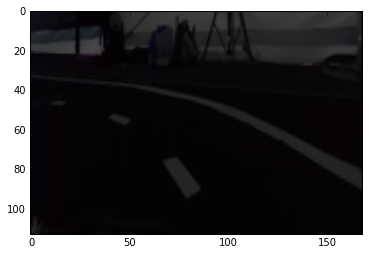

In [66]:
img, steering = preprocess_img(df.iloc[6])
print(steering)
plt.imshow(img)

In [67]:
## instead of above, and just plain training, let's use a generator to help randomly augment data

# df = df[(df['steering'] <= -0.01) | (df['steering'] >= 0.01)].reset_index(drop=True)

import sklearn
import cv2 as cv2
def generator(df, batch_size=256):
    
    while 1: # Loop forever so the generator never terminates
        x_sample = []
        y_sample = []
        pr_threshold = 1
        for i in range(batch_size):
            index = np.random.randint(len(df))
            row = df.iloc[index]
            image, steering = preprocess_img(row)
#             keep_pr = 0
#             while keep_pr == 0:
#                 image, steering = preprocess_img(row)
#                 pr_unif = np.random
#                 if abs(steering)<.001:
#                     pr_val = np.random.uniform()
#                     if pr_val>pr_threshold:
#                         keep_pr = 1
#                 else:
#                     keep_pr = 1
#             pr_threshold = 0.995 * pr_threshold
            x_sample.append(image)
            y_sample.append(steering)
        yield np.stack(x_sample), np.asarray(y_sample).reshape(batch_size, 1)
#         pr_threshold = 0.90 * pr_threshold

sample = shuffle_images(df)
train_generator = generator(sample)
validation_generator = generator(df)

In [48]:
# testing distribution
test_y = [next(train_generator)[1] for i in range(5)]
test_y = np.vstack(test_y)

plt.figure(figsize=(20,10))
plt.hist(test_y, bins=20)
# this will shuffle a dataframe df.sample(frac=1).reset_index(drop=True)

TypeError: 'NoneType' object has no attribute '__getitem__'

In [45]:
sample = shuffle_images(df)
train_generator = generator(sample)
model.optimizer.lr.assign(0.01)
history = model.fit_generator(train_generator, steps_per_epoch=20, epochs=10, verbose=1)

Epoch 1/10


Exception in thread Thread-16:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/data_utils.py", line 630, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-42-efd29d53a791>", line 16, in generator
    image, steering = preprocess_img(row)
  File "<ipython-input-36-b9548a1d82b8>", line 40, in preprocess_img
    img = crop_resize(img)
  File "<ipython-input-36-b9548a1d82b8>", line 28, in crop_resize
    img = img[150:, :]
TypeError: 'NoneType' object has no attribute '__getitem__'



StopIteration: 

In [ ]:
### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [44]:
model.save('./driving_net_model.h5')
model.save_weights("./driving_net_weights.h5")

In [11]:
from keras.models import load_model
model = load_model('./driving_net_model.h5')

In [ ]:
import random

# x, y = next(generator(df))


for i in range(1, 10):
    test_index=random.randint(0, len(df))
#     print(test_index)
    test_image = cv2.imread(df['file'][test_index])
    test_image = crop_resize(test_image)
    y  = df['steer'][test_index]
#     print(y[test_index])
    %time prediction = model.predict(test_image[None, :, :, :], batch_size=1)[0][0]
    print("index:", test_index, " actual: ", y, " prediction:", prediction, " diff:", prediction - y)


plt.imshow(test_image)